In [1]:
import torch
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
print(dev)

c:\Users\BraboDeBH\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
import torch
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split

transform = transforms.Compose(
    [
        transforms.Resize(size=(299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5875, 0.5591, 0.4995], [0.2855, 0.2831, 0.3047]),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

augmentation = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(),
        transforms.RandomRotation((0,360)),
        transforms.Resize(size=(299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5875, 0.5591, 0.4995], [0.2855, 0.2831, 0.3047]),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_data_path = 'DataSet/train/'
test_data_path = 'DataSet/test/'

dir_train = torchvision.datasets.ImageFolder(train_data_path,transform=transform)

train_data = torch.utils.data.DataLoader(dir_train,batch_size=32,shuffle=True,num_workers=8)

dir_test = torchvision.datasets.ImageFolder(test_data_path,transform=transform)
test_data = torch.utils.data.DataLoader(dir_test,batch_size=32,shuffle=True,num_workers=8)
len(train_data.dataset)

557

In [3]:
def train_one_epoch(NeuralNet,Loss,Optimizer,data_treino):
    NeuralNet.train(True)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0

    for i,data in enumerate(data_treino):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        Optimizer.zero_grad()
        output = NeuralNet(x)
        loss = Loss(output,y)
        current_loss += loss.item()
        loss.backward()
        Optimizer.step()
        
        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)

    return current_loss/(i+1), (current_accuracy/total_samples).to('cpu')

In [4]:
def validation_one_epoch(NeuralNet,Loss,val_data):
    NeuralNet.train(False)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = len(val_data.dataset)
    
    for i,data in enumerate(val_data):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        output = NeuralNet(x)
        loss = Loss(output,y)
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
    return current_loss/(i+1), (current_accuracy/total_samples).to('cpu')

In [5]:
from torch import nn
import torchvision.models as models

cnn = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
for i,param in enumerate(cnn.parameters()):
    param.requires_grad=False
cnn.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),
        )
cnn.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr=1e-3,momentum=0.9)

In [6]:
epochs = 10
train_loss_all_epoch = []
train_accuracy_all_epoch = []
val_loss_all_epoch = []
val_accuracy_all_epoch = []

for epoch in range(epochs):
    print(f'Starting epoch {epoch+1}')

    train_loss_per_epoch, train_accuracy_per_epoch = train_one_epoch(cnn,loss_function,optimizer,train_data)

    train_loss_all_epoch.append(train_loss_per_epoch)
    train_accuracy_all_epoch.append(train_accuracy_per_epoch)

    val_loss_per_epoch,val_accuracy_per_epoch = validation_one_epoch(cnn,loss_function,test_data)
    
    val_loss_all_epoch.append(val_loss_per_epoch)
    val_accuracy_all_epoch.append(val_accuracy_per_epoch)

    print(f'Train Loss: {train_loss_per_epoch}')
    print(f'Val Loss: {val_loss_per_epoch}')
    print(f'Train Accuracy: {train_accuracy_per_epoch}')
    print(f'Val Accuracy: {val_accuracy_per_epoch}')
    print()

print('Training process has finished.')

Starting epoch 1
Train Loss: 0.5903971923722161
Val Loss: 0.4052375674247742
Train Accuracy: 0.6732495427131653
Val Accuracy: 0.8928571343421936

Starting epoch 2
Train Loss: 0.28308259033494526
Val Loss: 0.30571077167987826
Train Accuracy: 0.9030520915985107
Val Accuracy: 0.8857142925262451

Starting epoch 3
Train Loss: 0.20071004455288252
Val Loss: 0.24397973269224166
Train Accuracy: 0.92998206615448
Val Accuracy: 0.9071428775787354

Starting epoch 4
Train Loss: 0.16715748235583305
Val Loss: 0.23734915554523467
Train Accuracy: 0.9371634125709534
Val Accuracy: 0.8642857074737549

Starting epoch 5
Train Loss: 0.11395672481093141
Val Loss: 0.263945272564888
Train Accuracy: 0.9587073922157288
Val Accuracy: 0.8928571343421936

Starting epoch 6
Train Loss: 0.0951634452988704
Val Loss: 0.1969131499528885
Train Accuracy: 0.9676840305328369
Val Accuracy: 0.9285714626312256

Starting epoch 7
Train Loss: 0.07743836277061039
Val Loss: 0.24712275862693786
Train Accuracy: 0.9730700254440308
Val Ac

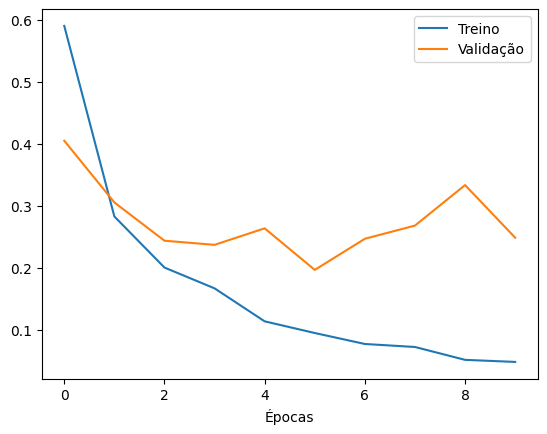

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_loss_all_epoch)
plt.plot(val_loss_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

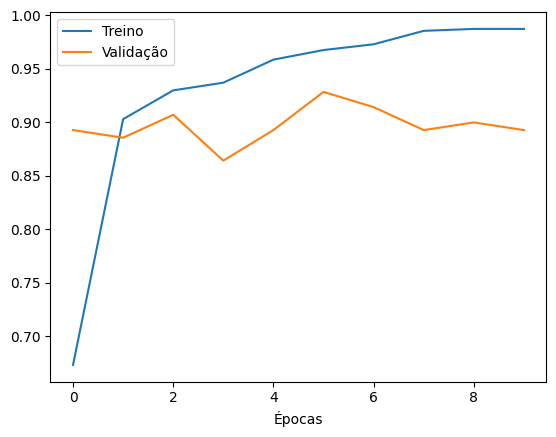

In [13]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy_all_epoch)
plt.plot(val_accuracy_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

In [14]:
from sklearn.metrics import classification_report

cnn.train(False)

all_pred = torch.tensor([]).to(device)
all_true = torch.tensor([]).to(device)

for data in test_data:
    x_test,y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = cnn(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    all_pred = torch.cat((all_pred,y_pred))
    all_true = torch.cat((all_true,y_test))

all_true = all_true.to('cpu')
all_pred = all_pred.to('cpu')
print(classification_report(all_true,all_pred,zero_division=1))

              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89        70
         1.0       0.90      0.89      0.89        70

    accuracy                           0.89       140
   macro avg       0.89      0.89      0.89       140
weighted avg       0.89      0.89      0.89       140



In [21]:
transform = transforms.Compose(
    [
        transforms.Resize(size=(299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5875, 0.5591, 0.4995], [0.2855, 0.2831, 0.3047])
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

dir_val = torchvision.datasets.ImageFolder('Teste',transform=transform)
val_data = torch.utils.data.DataLoader(dir_val,batch_size=32,shuffle=False,num_workers=0)

In [22]:
from sklearn.metrics import classification_report

cnn.train(False)

for data in val_data:
    x_test,y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = cnn(x_test)
    y_pred = y_pred.softmax(dim=1)
    print(y_pred)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    print(y_test,y_pred)

tensor([[6.9884e-01, 3.0116e-01],
        [8.5296e-03, 9.9147e-01],
        [6.9462e-04, 9.9931e-01],
        [1.9437e-06, 1.0000e+00],
        [5.7731e-13, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0, 1, 1, 1, 1], device='cuda:0') tensor([0, 1, 1, 1, 1], device='cuda:0')
